In [1]:
import torch
import numpy as np
from matplotlib import pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import warnings
warnings.simplefilter('ignore')

In [2]:
x = np.arange(10)
idx = np.arange(10)
np.random.shuffle(idx)
print(idx)
print(idx.argsort())
print(x[idx][idx.argsort()])

[4 6 0 1 7 2 9 3 5 8]
[2 3 5 7 0 8 1 4 9 6]
[0 1 2 3 4 5 6 7 8 9]


In [2]:
def diag(x:torch.Tensor):
    idx = torch.arange(x.shape[-1])
    return x[...,idx,idx]

def trace(x:torch.Tensor):
    return diag(x).sum(-1)
    

In [3]:
in_features = 784
expdim = 16
batchsize = 128
device = 'cuda'
# w = torch.randn(in_features, in_features, device=device)
v = torch.randn(in_features//expdim, expdim, expdim, device=device)
data = torch.randn(batchsize, in_features, device=device)
# z = data@torch.linalg.inv(w)
z = data
z = torch.reshape(z, (-1, in_features//expdim, 1, expdim))
z = z@torch.matrix_exp(v)
z = torch.reshape(z, (-1, in_features))
# z = z@w

# inv = torch.linalg.inv(w)
inv = torch.eye(in_features, device=device)
tmp = torch.zeros_like(inv)
for i in range(in_features//expdim):
    tmp[i*expdim:(i+1)*expdim,i*expdim:(i+1)*expdim] = torch.matrix_exp(-v[i])
inv = inv@tmp
# inv = torch.reshape(inv, (in_features, in_features//expdim, 1, expdim))
# inv = inv@torch.matrix_exp(-v)
# inv = torch.reshape(inv, (in_features, in_features))
# inv = inv@w

data_ = z@inv

(data-data_).square().mean().sqrt()


tensor(0.0001, device='cuda:0')

In [3]:
class BentIdentity(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
        
    def forward(self, z:torch.Tensor, logdet:torch.Tensor):
        logdet = logdet - torch.log(z/(2*torch.sqrt(z.square()+1)) + 1).sum(-1)
        z = (torch.sqrt((z.square()+1)) - 1)/2 + z
        return z, logdet
    
    def infer(self, z:torch.Tensor):
        return (4*z+2-torch.sqrt(4*(z.square()+z+1)))/3
    
class LieLinear(torch.nn.Module):
    def __init__(self, in_features, expdim, **kwargs) -> None:
        super().__init__()
        self.in_features = in_features
        self.expdim = expdim
        # self.w = torch.nn.parameter.Parameter(
        #     torch.zeros(self.in_features, self.in_features, **kwargs))
        self.v = torch.nn.parameter.Parameter(
            torch.zeros(self.in_features//self.expdim, self.expdim, self.expdim, **kwargs))
        self.b = torch.nn.parameter.Parameter(
            torch.zeros(self.in_features, **kwargs))
        self.inv = None
        self.idx = np.arange(self.in_features)
        np.random.shuffle(self.idx)
        self.reset_parameters()
        
    def forward(self, z, logdet):
        self.inv = None
        # z = z@torch.linalg.inv(self.w)
        z = torch.reshape(z, (-1, self.in_features//self.expdim, 1, self.expdim))
        z = z@torch.matrix_exp(self.v)
        z = torch.reshape(z, (-1, self.in_features))
        # z = z@self.w
        z = z + self.b
        z = z[:,self.idx]
        logdet = logdet - trace(self.v).sum(0)
        
        return z, logdet
    
    def infer(self, z):
        if self.inv is None:
            # self.inv = torch.linalg.inv(self.w)
            self.inv = torch.eye(self.in_features, device=self.v.device)
            self.inv = torch.reshape(self.inv, (self.in_features, self.in_features//self.expdim, 1, self.expdim))
            self.inv = self.inv@torch.matrix_exp(-self.v)
            self.inv = torch.reshape(self.inv, (self.in_features, self.in_features))
            # self.inv = self.inv@self.w
            
        return (z[:,self.idx.argsort()] - self.b)@self.inv
    
    def reset_parameters(self):
        # torch.nn.init.normal_(self.w, std=np.sqrt(1./self.in_features))
        torch.nn.init.normal_(self.v, std=np.sqrt(1./self.in_features))
        torch.nn.init.zeros_(self.b)
    
class LieFlow(torch.nn.Module):
    def __init__(self, input_shape, expdim, layersize, **kwargs) -> None:
        super().__init__()
        self.input_shape = input_shape
        self.in_features = np.array(input_shape).prod()
        self.layersize = layersize
        self.layers = torch.nn.ModuleList([LieLinear(self.in_features, expdim, **kwargs)])
        for _ in range(self.layersize):
            self.layers.append(BentIdentity())
            self.layers.append(LieLinear(self.in_features, expdim, **kwargs))
        
    def forward(self, data):
        z = torch.reshape(data, (-1, self.in_features))
        logdet = torch.zeros(data.shape[0], device=z.device)
        for i,layer in enumerate(self.layers):
            z, logdet = layer(z, logdet)
            
        return z, logdet     
    
    def infer(self, z):
        for i,layer in enumerate(reversed(self.layers)):
            z = layer.infer(z)
        
        data = torch.reshape(z, (-1,)+self.input_shape)
        return data
    
class FlowLoss(torch.nn.Module):
    def __init__(self, sigma) -> None:
        super().__init__()
        
        self.sigma = sigma
        
    def forward(self, z:torch.Tensor, logdet:torch.Tensor):
        loss = (z.square()/(2*self.sigma**2) + 0.5*np.log(2*np.pi*self.sigma)).mean(0).sum() + logdet.mean()
        return loss

class Normalize(torch.nn.Module):
    def __init__(self) -> None:
        super().__init__()
    
    def forward(self, x:torch.Tensor):
        x = x - x.mean()
        x = x / x.std()
        return x

In [8]:
batchsize = 10000

transform = transforms.Compose([
    transforms.ToTensor(),
    ])

train_dataset = datasets.MNIST(
    '../../data',
    train = True,
    download = True,   
    transform = transform
    )

test_dataset = datasets.MNIST(
    '../../data/', 
    train = False,
    transform = transform
    )

train_dataloader=DataLoader(
    train_dataset,
    batch_size =batchsize,
    shuffle = True)
test_dataloader=DataLoader(
    test_dataset,     
    batch_size=batchsize,
    shuffle=True)

In [12]:
device = 'cuda'
epoch = 100
model = LieFlow((1,28,28), 16, 4, device=device)
loss_fn = FlowLoss(0.1)
optimizer = torch.optim.Adam(model.parameters())

In [17]:
z = torch.randn(10, 784, device=device)
data = model.infer(z)
z_,_ = model(data)
(z-z_).square().mean().sqrt()
# data = data.cpu().detach().numpy()

tensor(0.0113, device='cuda:0', grad_fn=<SqrtBackward0>)

In [13]:
nll = np.arange(epoch)
det = np.arange(epoch)
for i in range(epoch):
    n = 0
    for data, label in train_dataloader:
        data = data.to(device)
        z, logdet = model(data)
        latent_nll = z.square().mean(0).sum()
        logdet = logdet.mean()
        loss = latent_nll + logdet
        
        nll[i] += latent_nll.item()
        det[i] += logdet.item()
        n += 1
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        print(f"Epoch: {i}/{epoch}, nll: {latent_nll.item()}, logdet: {logdet.item()}", '\r', end='')
    
    nll[i] /= n
    det[i] /= n


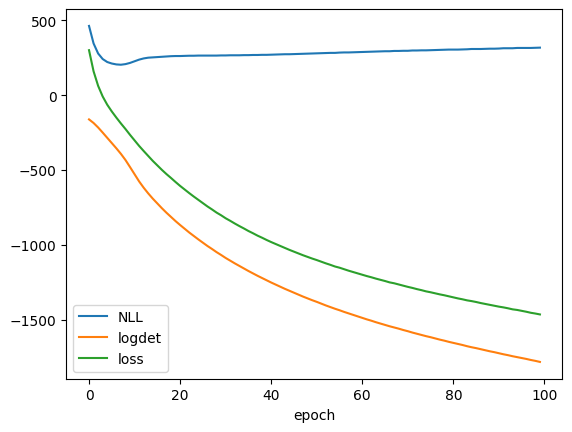

In [15]:
plt.plot(nll, label='NLL')
plt.plot(det, label='logdet')
plt.plot(nll+det, label='loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

In [20]:
train_dataset[1][0].shape

torch.Size([1, 28, 28])

tensor(0.6177, device='cuda:0', grad_fn=<StdBackward0>)


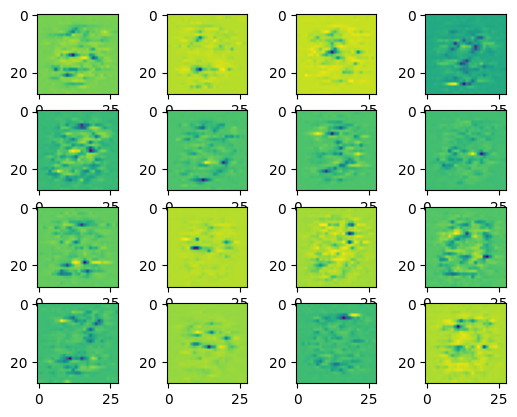

In [16]:
data = torch.zeros(16,1,28,28)
for i in range(16):
    data[i] = train_dataset[i][0]
z,_ = model(data.to(device))
print(z.std())
z = torch.randn(16, 784, device=device)
data = model.infer(z)
data = data.cpu().detach().numpy()
fig,ax = plt.subplots(4,4)
for i in range(4):
    for j in range(4):
        ax[i,j].imshow(data[4*i+j,0])
plt.show()

In [ ]:
z = torch.randn(10, 784, device=device)
data = model.infer(z)
z_,_ = model(data)
(z-z_).square().mean().sqrt()
# data = data.cpu().detach().numpy()

/tmp/ipykernel_737002/2886581127.py:31: UserWarning: An output with one or more elements was resized since it had shape [196, 4, 4], which does not match the required output shape [1, 196, 4, 4]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  self.inv = self.inv@torch.matrix_exp(-self.v)
/tmp/ipykernel_737002/2886581127.py:19: UserWarning: An output with one or more elements was resized since it had shape [196, 4, 4], which does not match the required output shape [1, 196, 4, 4]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/nativ

tensor(0.2348, device='cuda:0', grad_fn=<SqrtBackward0>)

In [ ]:
z = torch.randn(10, 784, device=device)
data = model.infer(z)
z_,_ = model(data)
(z-z_).square().mean().sqrt()
# data = data.cpu().detach().numpy()

/tmp/ipykernel_737002/2886581127.py:31: UserWarning: An output with one or more elements was resized since it had shape [196, 4, 4], which does not match the required output shape [1, 196, 4, 4]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/native/Resize.cpp:17.)
  self.inv = self.inv@torch.matrix_exp(-self.v)
/tmp/ipykernel_737002/2886581127.py:19: UserWarning: An output with one or more elements was resized since it had shape [196, 4, 4], which does not match the required output shape [1, 196, 4, 4]. This behavior is deprecated, and in a future PyTorch release outputs will not be resized unless they have zero elements. You can explicitly reuse an out tensor t by resizing it, inplace, to zero elements with t.resize_(0). (Triggered internally at  ../aten/src/ATen/nativ

tensor(0.2348, device='cuda:0', grad_fn=<SqrtBackward0>)

In [37]:
m = torch.randn(4,4)
s = torch.matrix_exp(m)
det = torch.det(s)
det_ = torch.exp(trace(m))
torch.dist(det,det_)

tensor(7.4506e-08)